<a href="https://colab.research.google.com/github/EllouziMedAmin/DSWithPytorch/blob/main/Sentiment_Classification_on_Yelp_Reviews_using_DistilBERT_and_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [2]:
# packages
from huggingface_hub import list_datasets
from datasets import load_dataset
import pandas as pd
import seaborn as sns

In [3]:
#available datasets
datasets = list_datasets()
for dataset in datasets:
    print(dataset)
    break

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetInfo(id='nvidia/Llama-Nemotron-Post-Training-Dataset-v1', author='nvidia', sha='ed905e6239c9d191e4c965a403dde07a5383b5eb', created_at=datetime.datetime(2025, 3, 13, 21, 1, 9, tzinfo=datetime.timezone.utc), last_modified=datetime.datetime(2025, 3, 18, 15, 56, 14, tzinfo=datetime.timezone.utc), private=False, gated=False, disabled=False, downloads=4338, downloads_all_time=None, likes=202, paperswithcode_id=None, tags=['license:cc-by-4.0', 'size_categories:10M<n<100M', 'format:json', 'modality:text', 'library:datasets', 'library:pandas', 'library:mlcroissant', 'library:polars', 'region:us'], trending_score=202, card_data=None, siblings=None)


In [4]:
#import the yelp dataset
dataset=load_dataset('yelp_review_full')

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [6]:
train_ds=dataset['train']

In [7]:
train_ds

Dataset({
    features: ['label', 'text'],
    num_rows: 650000
})

In [8]:
train_ds[0]

{'label': 4,
 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}

In [9]:
train_ds.features

{'label': ClassLabel(names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None),
 'text': Value(dtype='string', id=None)}

In [10]:
#convert to pandas
train_df=train_ds.to_pandas()

In [11]:
train_df.head()

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


In [12]:
val_count=train_df['label'].value_counts()

<Axes: ylabel='count'>

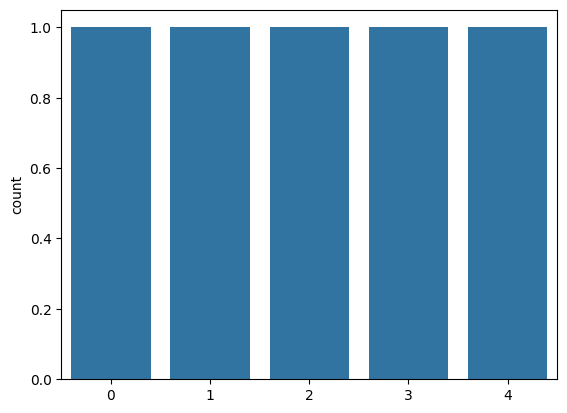

In [13]:
sns.countplot(val_count.tolist())

In [14]:
#undrestanding the texts
# count of words per review(class)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

<Axes: xlabel='label', ylabel='word_count'>

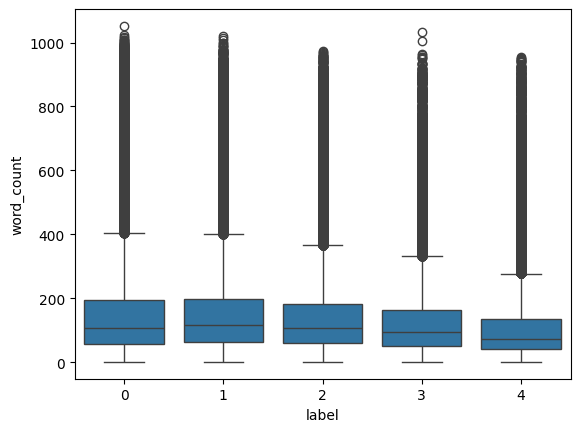

In [15]:
sns.boxplot(x='label', y='word_count', data=train_df)


In [16]:
import torch
from transformers import AutoModel, DistilBertTokenizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

In [17]:
train_ds=train_ds.select(range(300000))

In [18]:
#Model and Tokenizer
model_name = 'distilbert-base-uncased'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoModel.from_pretrained(model_name).to(device)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [19]:
# Tokenizer
text = 'Hello, this is a sample sentence!'

encoded_text = tokenizer(text, return_tensors='pt')
encoded_text

{'input_ids': tensor([[ 101, 7592, 1010, 2023, 2003, 1037, 7099, 6251,  999,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [20]:
# Tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'][0])

tokenizer.convert_tokens_to_string(tokens)

'[CLS] hello , this is a sample sentence ! [SEP]'

In [21]:
# how large is the vocabulary?
tokenizer.vocab_size

30522

In [22]:
# Max context length
max_context_length = tokenizer.model_max_length
max_context_length

512

In [23]:
def tokenize_text(batch):
    # padding...texts are filled with zeros based to longest example
    # truncation...texts are cut off after max_context_length
    encodings = tokenizer(batch['text'], return_tensors='pt', padding='max_length', truncation=True, max_length=512)
    return {key: tensor for key, tensor in encodings.items()}  # Keep tensors on CPU for dataset formatting

In [24]:
yelp_encodings = train_ds.map(tokenize_text, batched=True, batch_size=128)

Map:   0%|          | 0/300000 [00:00<?, ? examples/s]

In [25]:
yelp_encodings.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])  # encodings need to be converted to torch tensors
def get_last_hidden_state(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}  # Move inputs to GPU
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        # [:, 0] refers to CLS token for complete sentence representation
    return {'hidden_state': last_hidden_state[:, 0]}


In [26]:
yelp_hidden_states = yelp_encodings.map(get_last_hidden_state, batched=True, batch_size=128)
# will have additional column 'hidden_state'


Map:   0%|          | 0/300000 [00:00<?, ? examples/s]

In [28]:
!mkdir model

In [29]:
import joblib
joblib.dump(yelp_hidden_states, 'model/yelp_hidden_states.joblib')

['model/yelp_hidden_states.joblib']

In [30]:
cutoff = 300000*.8
cutoff = int(cutoff)
print(cutoff)

240000


In [31]:
import numpy as np

In [32]:
X_train = np.array(yelp_hidden_states['hidden_state'][:cutoff])
y_train = np.array(yelp_hidden_states['label'][:cutoff])
X_test = np.array(yelp_hidden_states['hidden_state'][cutoff: ])
y_test = np.array(yelp_hidden_states['label'][cutoff: ])
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (240000, 768), y_train.shape: (240000,)
X_test.shape: (60000, 768), y_test.shape: (60000,)


In [33]:
import cupy as cp
from cuml.svm import SVC
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

In [34]:
# Convert to GPU DataFrame (cudf) for cuML Compatibility
X_train_df = cudf.DataFrame(X_train)
y_train_df = cudf.Series(y_train)
X_test_df = cudf.DataFrame(X_test)
y_test_df = cudf.Series(y_test)

In [35]:
# Dummy Model (CPU-based, since cuML has no DummyClassifier)
dummy_model = DummyClassifier(strategy='most_frequent')  # CPU
dummy_model.fit(cp.asnumpy(X_train), cp.asnumpy(y_train))  # Convert back to CPU
dummy_score = dummy_model.score(cp.asnumpy(X_test), cp.asnumpy(y_test))
print(f"Dummy Model Score: {dummy_score}")

Dummy Model Score: 0.19805


In [36]:
# SVM (GPU-based)
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_df, y_train_df)
svm_score = svm_model.score(X_test_df, y_test_df)
print(f"SVM Model Score: {svm_score}")

[2025-03-24 19:12:03.101] [CUML] [warning] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
SVM Model Score: 0.5754500031471252


In [37]:
# Logistic Regression (GPU-based)
lr_model = LogisticRegression()
lr_model.fit(X_train_df, y_train_df)
lr_score = lr_model.score(X_test_df, y_test_df)
print(f"Logistic Regression Score: {lr_score}")

[2025-03-24 19:14:53.269] [CUML] [warning] L-BFGS: max iterations reached
[2025-03-24 19:14:53.270] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
Logistic Regression Score: 0.5734500288963318


In [38]:
# Random Forest (GPU-based)
rf_model = RandomForestClassifier(n_estimators=100)  # More trees = better accuracy
rf_model.fit(X_train_df, y_train_df)
rf_score = rf_model.score(X_test_df, y_test_df)
print(f"Random Forest Score: {rf_score}")

Random Forest Score: 0.5132333040237427


In [39]:
import xgboost as xgb

In [41]:
xgb_model = xgb.XGBClassifier(
    tree_method='gpu_hist',  # GPU-accelerated tree construction
    predictor='gpu_predictor',  # Ensure GPU is used
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [43]:
# Train XGBoost model
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:18:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:18:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [44]:
# Evaluate XGBoost
xgb_score = xgb_model.score(X_test, y_test)
print(f"XGBoost Score: {xgb_score}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:19:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:19:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Score: 0.5363833333333333
